In [31]:
from typing_extensions import Literal
from langchain_core.tools import tool
from langchain_groq import ChatGroq
from langgraph.graph import MessagesState, StateGraph,START,END
from langgraph.types import Command
from dotenv import load_dotenv
from IPython.display import Image, display
from langchain_openai import ChatOpenAI
from langchain_core.messages import BaseMessage, HumanMessage
from langgraph.prebuilt import create_react_agent
from typing import Annotated
from langchain_experimental.utilities import PythonREPL
from langchain_community.tools import DuckDuckGoSearchRun
import matplotlib.pyplot as plt

In [2]:
load_dotenv()
openai_model = ChatOpenAI(model="gpt-4")

In [4]:
openai_model.invoke("hi").content

'Hello! How can I assist you today?'

In [5]:
from langchain_groq import ChatGroq
groq_model = ChatGroq(model="deepseek-r1-distill-llama-70b")

In [7]:
groq_model.invoke("hi").content

'<think>\n\n</think>\n\nHello! How can I assist you today? 😊'

## Tool 1 (DuckDuckGo Web Search):

In [8]:
search_tool = DuckDuckGoSearchRun()

In [12]:
search_tool.invoke("what is a gdp of india?")

c:\Users\souma\anaconda3\envs\rag\Lib\site-packages\langchain_community\utilities\duckduckgo_search.py:63: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  with DDGS() as ddgs:


"66 rows · Mar 6, 2025 · India contributes 3.70% of the entire world's GDP. India's share of the world economy increased from 1.08 percent in 1993 to the current estimate of 3.70 percent in … May 31, 2025 · India Becomes World’s 4th Largest Economy Introduction India has overtaken Japan to become the world’s 4th largest economy, with its GDP surpassing $4 trillion, as … May 13, 2025 · Understand India’s real GDP—what it is, how it’s calculated, and why it matters to the economy and everyday decisions. May 26, 2025 · Discover the current size of the Indian economy and explore its unique features, characteristics and key sectors. Also, learn about challenges and opportunities for the Indian … May 30, 2025 · India GDP Data Updates, May 30: The National Statistics Office (NSO), Ministry of Statistics and Programme Implementation (MoSPI), has released the Provisional Estimates of …"

## Tool 2 (Python REPL Coder):

In [13]:
repl = PythonREPL()

In [14]:
code = """
x = 5
y = x * 2
print(y)
"""

In [15]:
repl.run(code)

Python REPL can execute arbitrary code. Use with caution.


'10\n'

In [16]:
@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    
    result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"
    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )

<>:13: SyntaxWarning: invalid escape sequence '\`'
<>:13: SyntaxWarning: invalid escape sequence '\`'
<>:13: SyntaxWarning: invalid escape sequence '\`'
<>:13: SyntaxWarning: invalid escape sequence '\`'
C:\Users\souma\AppData\Local\Temp\ipykernel_1336\290981387.py:13: SyntaxWarning: invalid escape sequence '\`'
  result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"
C:\Users\souma\AppData\Local\Temp\ipykernel_1336\290981387.py:13: SyntaxWarning: invalid escape sequence '\`'
  result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"


In [17]:
def make_system_prompt(instruction:str)->str:
    return  (
        "You are a helpful AI assistant, collaborating with other assistants."
        " Use the provided tools to progress towards answering the question."
        " If you are unable to fully answer, that's OK, another assistant with different tools "
        " will help where you left off. Execute what you can to make progress."
        " If you or any of the other assistants have the final answer or deliverable,"
        " prefix your response with FINAL ANSWER so the team knows to stop."
        f"\n{instruction}"
    )

"You are a helpful AI assistant, collaborating with other assistants. Use the provided tools to progress towards answering the question. If you are unable to fully answer, that's OK, another assistant with different tools  will help where you left off. Execute what you can to make progress. If you or any of the other assistants have the final answer or deliverable, prefix your response with FINAL ANSWER so the team knows to stop.\nYou can only do research. You are working with a chart generator colleague."

## Get Next Node/Agent:

In [18]:
def get_next_node(last_message:BaseMessage, goto:str):
    if "FINAL ANSWER" in last_message.content:
        # Any agent decided the work is done
        return END
    return goto

## AGENT 1 (Research Node/Agent):

In [19]:
def research_node(state:MessagesState)->Command[Literal["chart_generator", END]]:
    
    research_agent = create_react_agent(
    groq_model,
    tools=[search_tool],
    prompt=make_system_prompt(
        "You can only do research. You are working with a chart generator colleague."
    ),
    )
    
    result = research_agent.invoke(state)
    
    goto = get_next_node(result["messages"][-1], "chart_generator")
    
    result["messages"][-1] = HumanMessage(content=result["messages"][-1].content, name="researcher")
    
    return Command(update={"messages": result["messages"]},goto=goto)

## AGENT 2 (Chart Node/Agent):

In [20]:
def chart_node(state:MessagesState)-> Command[Literal["researcher", END]]:
    
    chart_agent = create_react_agent(
    groq_model,
    [python_repl_tool],
    prompt=make_system_prompt(
        "You can only generate charts. You are working with a researcher colleague."
    ),
    )
    result = chart_agent.invoke(state)
    
    goto = get_next_node(result["messages"][-1], "researcher")
    
    result["messages"][-1] = HumanMessage(content=result["messages"][-1].content, name="chart_generator")
    
    return Command(update={"messages": result["messages"]},goto=goto)

## Workflow:

In [21]:
from langgraph.graph import StateGraph, START

workflow = StateGraph(MessagesState)
workflow.add_node("researcher", research_node)
workflow.add_node("chart_generator", chart_node)

workflow.add_edge(START, "researcher")
app = workflow.compile()

## APP:

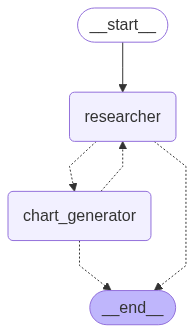

In [22]:
display(Image(app.get_graph().draw_mermaid_png()))

## Response:

c:\Users\souma\anaconda3\envs\rag\Lib\site-packages\langchain_community\utilities\duckduckgo_search.py:63: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  with DDGS() as ddgs:
c:\Users\souma\anaconda3\envs\rag\Lib\site-packages\langchain_community\utilities\duckduckgo_search.py:63: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  with DDGS() as ddgs:


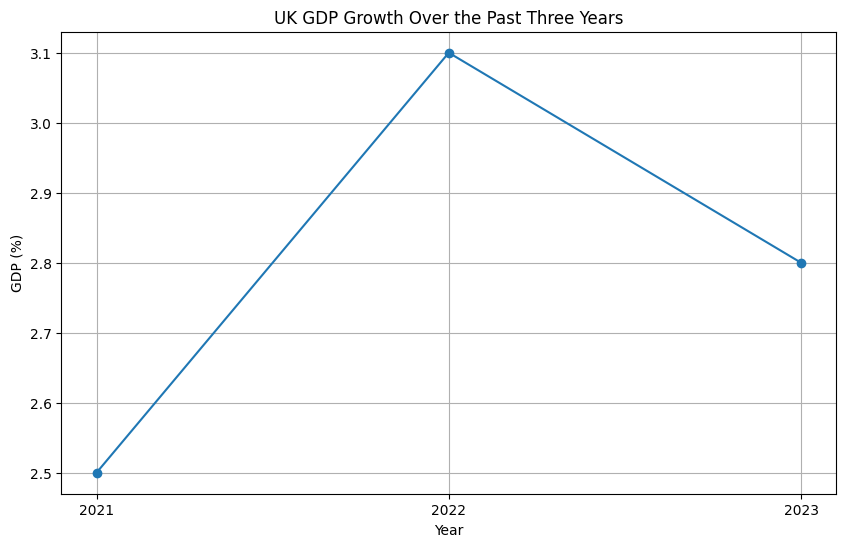

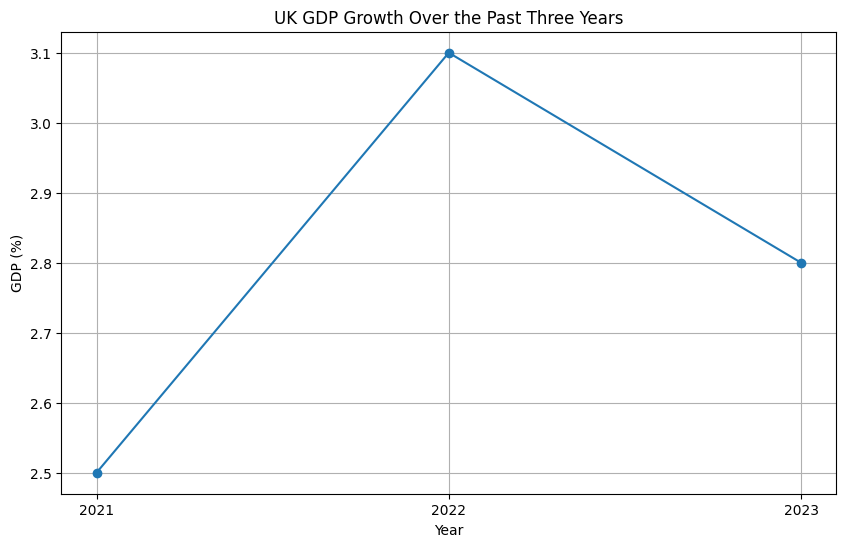

Task chart_generator with path ('__pregel_pull', 'chart_generator') wrote to unknown channel branch:to:__end__, ignoring it.


{'messages': [HumanMessage(content="get the UK's GDP over the past 3 years, then make a line chart of it.Once you make the chart, finish.", additional_kwargs={}, response_metadata={}, id='efcca002-ac83-47e9-8b6a-ccbafe5dc285'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'ej13k8s3k', 'function': {'arguments': '{"query":"UK GDP past 3 years"}', 'name': 'duckduckgo_search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 217, 'prompt_tokens': 281, 'total_tokens': 498, 'completion_time': 0.814651846, 'prompt_time': 0.034387715, 'queue_time': 0.306435722, 'total_time': 0.849039561}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--69a89a38-4528-4a27-a18b-5fae12dbde6d-0', tool_calls=[{'name': 'duckduckgo_search', 'args': {'query': 'UK GDP past 3 years'}, 'id': 'ej13k8s3k', 'type': 'tool_call'}], usage_metadata={'input_tokens': 281, 'output_toke

In [32]:
app.invoke({"messages": [("user","get the UK's GDP over the past 3 years, then make a line chart of it.Once you make the chart, finish.")],})